<a href="https://colab.research.google.com/github/umang66782/Plaksha/blob/main/GAN_celeb_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generate human faces using Generative Adversial Network using VAE on the celebA dataset. 



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Dropout
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf

In [ ]:
n_images = 10000
batch_size = 64
latent_dim = 100
n_epoch = 20
img_shape = (64,64, 3)

In [ ]:
data = '../input/celeba-dataset/img_align_celeba/img_align_celeba' 
images = os.listdir(data)
images = images[:n_images]

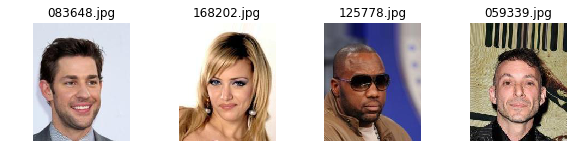

In [ ]:
plt.figure(figsize=(10,10))
for i, name in enumerate(images[:4]):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(data + '/' + name)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

In [ ]:
def get_data(data_path) :
    x = []
    for filename in data_path :
        img = img_to_array(load_img(data + "/" + filename, target_size = img_shape[:2]))
        x.append(img)
    x = np.array(x).astype('float32')
    x = x / 255
    return x

dataset = get_data(images)

In [ ]:
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.5))
   
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])
    return model

In [ ]:
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128 * 16 * 16, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Reshape((16, 16, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model



In [ ]:
gen = define_generator(latent_dim)
gen.summary() 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 64, 64, 128)       262272    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 64, 64, 128)      

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    input_x = randn(latent_dim * n_samples)
    input_x = input_x.reshape(n_samples, latent_dim)
    return input_x


def generate_fake_samples(g_model, latent_dim, n_samples):
    input_x = generate_latent_points(latent_dim, n_samples)
    x = g_model.predict(input_x)
    y = np.zeros((n_samples, 1))
    return x, y

In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer= opt)
    return model


def get_real_samples(dataset, n_samples):
    z = randint(0, dataset.shape[0], n_samples)
    x = dataset[z]
    y = np.ones((n_samples, 1))
    return x, y



In [ ]:
def show_generated(generated,epoch):
    plt.figure(figsize=(10,10))
    _ , x = plt.subplots(1,3)
    
    x[0].imshow(generated[0])
    x[1].imshow(generated[1])
    x[2].imshow(generated[2])
    plt.show()    

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):

    x_real, y_real = get_real_samples(dataset, n_samples)
    _, accuracy_real = d_model.evaluate(x_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, accuracy_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
    print('>Accuracy [real: %.0f%%, fake: %.0f%%]' % (accuracy_real*100, accuracy_fake*100))
    show_generated(x_fake, epoch)    

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=20, n_batch=64):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(bat_per_epo):
            x_real, y_real = get_real_samples(dataset, half_batch)
            dec_loss1, _ = d_model.train_on_batch(x_real, y_real)
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            dec_loss2, _ = d_model.train_on_batch(x_fake, y_fake)
            x_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            gen_loss = gan_model.train_on_batch(x_gan, y_gan)
        print('Epoch: %d,  Loss: Dec_real = %.3f, Dec_fake = %.3f,  Gen_loss = %.3f' %   (i+1, dec_loss1, dec_loss2, gen_loss))
        if (i+1) % 20 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)     

In [ ]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan = define_gan(generator, discriminator)

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1,  Loss: Dec_real = 0.575, Dec_fake = 0.711,  Gen_loss = 1.009
Epoch: 2,  Loss: Dec_real = 0.730, Dec_fake = 0.724,  Gen_loss = 0.823
Epoch: 3,  Loss: Dec_real = 0.653, Dec_fake = 0.746,  Gen_loss = 0.817
Epoch: 4,  Loss: Dec_real = 0.646, Dec_fake = 0.651,  Gen_loss = 0.853
Epoch: 5,  Loss: Dec_real = 0.667, Dec_fake = 0.648,  Gen_loss = 0.916
Epoch: 6,  Loss: Dec_real = 0.630, Dec_fake = 0.561,  Gen_loss = 1.230
Epoch: 7,  Loss: Dec_real = 0.706, Dec_fake = 0.652,  Gen_loss = 0.875
Epoch: 8,  Loss: Dec_real = 0.698, Dec_fake = 0.542,  Gen_loss = 1.191
Epoch: 9,  Loss: Dec_real = 0.605, Dec_fake = 0.621,  Gen_loss = 1.109
Epoch: 10,  Loss: Dec_real = 0.598, Dec_fake = 0.659,  Gen_loss = 1.043
Epoch: 11,  Loss: Dec_real = 0.604, Dec_fake = 0.581,  Gen_loss = 1.303
Epoch: 12,  Loss: Dec_real = 0.872, Dec_fake = 0.689,  Gen_loss = 1.002
Epoch: 13,  Loss: Dec_real = 0.801, Dec_fake = 0.566,  Gen_loss = 1.021
Epoch: 14,  Loss: Dec_real = 0.586, Dec_fake = 0.503,  Gen_loss = 1.237
E

<Figure size 720x720 with 0 Axes>

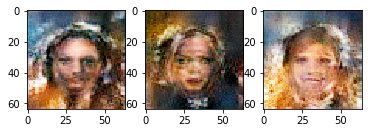

Epoch: 21,  Loss: Dec_real = 0.698, Dec_fake = 0.537,  Gen_loss = 1.249
Epoch: 22,  Loss: Dec_real = 0.661, Dec_fake = 0.488,  Gen_loss = 1.151
Epoch: 23,  Loss: Dec_real = 0.774, Dec_fake = 0.563,  Gen_loss = 1.658
Epoch: 24,  Loss: Dec_real = 0.574, Dec_fake = 0.637,  Gen_loss = 1.217
Epoch: 25,  Loss: Dec_real = 0.618, Dec_fake = 0.422,  Gen_loss = 1.445
Epoch: 26,  Loss: Dec_real = 0.520, Dec_fake = 0.358,  Gen_loss = 1.550
Epoch: 27,  Loss: Dec_real = 0.666, Dec_fake = 0.547,  Gen_loss = 1.358
Epoch: 28,  Loss: Dec_real = 0.643, Dec_fake = 0.400,  Gen_loss = 1.788
Epoch: 29,  Loss: Dec_real = 0.538, Dec_fake = 0.390,  Gen_loss = 1.545
Epoch: 30,  Loss: Dec_real = 0.442, Dec_fake = 0.439,  Gen_loss = 2.006
Epoch: 31,  Loss: Dec_real = 0.494, Dec_fake = 0.408,  Gen_loss = 2.458
Epoch: 32,  Loss: Dec_real = 6.068, Dec_fake = 2.351,  Gen_loss = 5.819
Epoch: 33,  Loss: Dec_real = 0.422, Dec_fake = 0.386,  Gen_loss = 1.851
Epoch: 34,  Loss: Dec_real = 0.583, Dec_fake = 0.531,  Gen_loss 

<Figure size 720x720 with 0 Axes>

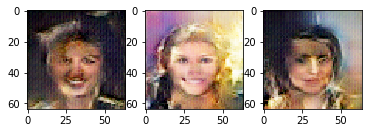

Epoch: 41,  Loss: Dec_real = 0.700, Dec_fake = 0.590,  Gen_loss = 1.851
Epoch: 42,  Loss: Dec_real = 0.617, Dec_fake = 0.434,  Gen_loss = 1.900
Epoch: 43,  Loss: Dec_real = 0.611, Dec_fake = 0.470,  Gen_loss = 2.181
Epoch: 44,  Loss: Dec_real = 0.615, Dec_fake = 0.411,  Gen_loss = 1.723
Epoch: 45,  Loss: Dec_real = 0.642, Dec_fake = 0.577,  Gen_loss = 1.624
Epoch: 46,  Loss: Dec_real = 0.486, Dec_fake = 0.209,  Gen_loss = 2.377
Epoch: 47,  Loss: Dec_real = 0.702, Dec_fake = 0.534,  Gen_loss = 3.224
Epoch: 48,  Loss: Dec_real = 0.444, Dec_fake = 0.577,  Gen_loss = 1.336
Epoch: 49,  Loss: Dec_real = 0.597, Dec_fake = 0.598,  Gen_loss = 1.052
Epoch: 50,  Loss: Dec_real = 0.599, Dec_fake = 0.387,  Gen_loss = 1.363
Epoch: 51,  Loss: Dec_real = 0.799, Dec_fake = 0.582,  Gen_loss = 1.502
Epoch: 52,  Loss: Dec_real = 0.407, Dec_fake = 0.434,  Gen_loss = 1.694
Epoch: 53,  Loss: Dec_real = 0.558, Dec_fake = 0.516,  Gen_loss = 1.722
Epoch: 54,  Loss: Dec_real = 0.502, Dec_fake = 0.334,  Gen_loss 

<Figure size 720x720 with 0 Axes>

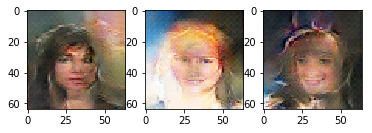

Epoch: 61,  Loss: Dec_real = 0.594, Dec_fake = 0.540,  Gen_loss = 2.333
Epoch: 62,  Loss: Dec_real = 0.543, Dec_fake = 0.484,  Gen_loss = 1.573
Epoch: 63,  Loss: Dec_real = 0.711, Dec_fake = 0.454,  Gen_loss = 1.514
Epoch: 64,  Loss: Dec_real = 0.438, Dec_fake = 0.443,  Gen_loss = 1.962
Epoch: 65,  Loss: Dec_real = 0.435, Dec_fake = 0.334,  Gen_loss = 1.988
Epoch: 66,  Loss: Dec_real = 0.504, Dec_fake = 0.442,  Gen_loss = 2.605
Epoch: 67,  Loss: Dec_real = 0.354, Dec_fake = 0.332,  Gen_loss = 1.708
Epoch: 68,  Loss: Dec_real = 0.669, Dec_fake = 0.361,  Gen_loss = 1.902
Epoch: 69,  Loss: Dec_real = 0.508, Dec_fake = 0.436,  Gen_loss = 2.157
Epoch: 70,  Loss: Dec_real = 0.316, Dec_fake = 0.284,  Gen_loss = 1.785
Epoch: 71,  Loss: Dec_real = 0.329, Dec_fake = 0.389,  Gen_loss = 1.820
Epoch: 72,  Loss: Dec_real = 0.406, Dec_fake = 0.343,  Gen_loss = 2.071
Epoch: 73,  Loss: Dec_real = 0.403, Dec_fake = 0.354,  Gen_loss = 2.524
Epoch: 74,  Loss: Dec_real = 0.655, Dec_fake = 0.432,  Gen_loss 

<Figure size 720x720 with 0 Axes>

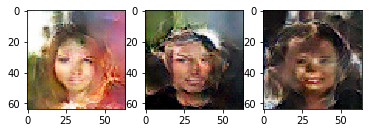

Epoch: 81,  Loss: Dec_real = 0.394, Dec_fake = 0.388,  Gen_loss = 1.903
Epoch: 82,  Loss: Dec_real = 0.704, Dec_fake = 0.617,  Gen_loss = 2.281
Epoch: 83,  Loss: Dec_real = 0.396, Dec_fake = 0.414,  Gen_loss = 1.976
Epoch: 84,  Loss: Dec_real = 0.690, Dec_fake = 0.568,  Gen_loss = 1.313
Epoch: 85,  Loss: Dec_real = 0.641, Dec_fake = 0.399,  Gen_loss = 1.308
Epoch: 86,  Loss: Dec_real = 0.489, Dec_fake = 0.416,  Gen_loss = 1.749
Epoch: 87,  Loss: Dec_real = 0.426, Dec_fake = 0.328,  Gen_loss = 1.597
Epoch: 88,  Loss: Dec_real = 0.613, Dec_fake = 0.395,  Gen_loss = 1.733
Epoch: 89,  Loss: Dec_real = 0.444, Dec_fake = 0.409,  Gen_loss = 2.000
Epoch: 90,  Loss: Dec_real = 0.689, Dec_fake = 0.408,  Gen_loss = 2.394
Epoch: 91,  Loss: Dec_real = 0.503, Dec_fake = 0.127,  Gen_loss = 3.470
Epoch: 92,  Loss: Dec_real = 0.780, Dec_fake = 0.415,  Gen_loss = 1.819
Epoch: 93,  Loss: Dec_real = 0.000, Dec_fake = 0.000,  Gen_loss = 82.013
Epoch: 94,  Loss: Dec_real = 0.782, Dec_fake = 0.773,  Gen_loss

<Figure size 720x720 with 0 Axes>

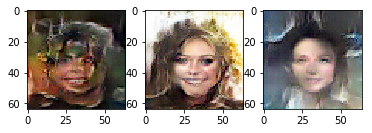

Epoch: 101,  Loss: Dec_real = 0.668, Dec_fake = 0.492,  Gen_loss = 1.810
Epoch: 102,  Loss: Dec_real = 0.414, Dec_fake = 0.304,  Gen_loss = 2.210
Epoch: 103,  Loss: Dec_real = 0.332, Dec_fake = 0.300,  Gen_loss = 2.094
Epoch: 104,  Loss: Dec_real = 0.599, Dec_fake = 0.486,  Gen_loss = 2.029
Epoch: 105,  Loss: Dec_real = 0.647, Dec_fake = 0.516,  Gen_loss = 1.900
Epoch: 106,  Loss: Dec_real = 0.553, Dec_fake = 0.428,  Gen_loss = 2.409
Epoch: 107,  Loss: Dec_real = 0.391, Dec_fake = 0.383,  Gen_loss = 1.809
Epoch: 108,  Loss: Dec_real = 0.798, Dec_fake = 0.984,  Gen_loss = 1.955
Epoch: 109,  Loss: Dec_real = 0.765, Dec_fake = 0.621,  Gen_loss = 1.360
Epoch: 110,  Loss: Dec_real = 0.609, Dec_fake = 0.430,  Gen_loss = 1.424
Epoch: 111,  Loss: Dec_real = 0.573, Dec_fake = 0.399,  Gen_loss = 1.490
Epoch: 112,  Loss: Dec_real = 0.673, Dec_fake = 0.477,  Gen_loss = 1.357
Epoch: 113,  Loss: Dec_real = 0.460, Dec_fake = 0.354,  Gen_loss = 1.737
Epoch: 114,  Loss: Dec_real = 0.684, Dec_fake = 0.4

<Figure size 720x720 with 0 Axes>

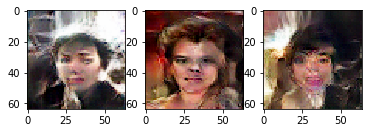

Epoch: 121,  Loss: Dec_real = 0.420, Dec_fake = 0.360,  Gen_loss = 2.217
Epoch: 122,  Loss: Dec_real = 0.524, Dec_fake = 0.321,  Gen_loss = 1.980
Epoch: 123,  Loss: Dec_real = 0.731, Dec_fake = 0.301,  Gen_loss = 2.045
Epoch: 124,  Loss: Dec_real = 0.144, Dec_fake = 0.176,  Gen_loss = 2.639
Epoch: 125,  Loss: Dec_real = 0.437, Dec_fake = 0.387,  Gen_loss = 2.083
Epoch: 126,  Loss: Dec_real = 0.628, Dec_fake = 0.585,  Gen_loss = 1.500
Epoch: 127,  Loss: Dec_real = 0.679, Dec_fake = 0.490,  Gen_loss = 1.396
Epoch: 128,  Loss: Dec_real = 0.550, Dec_fake = 0.368,  Gen_loss = 1.598
Epoch: 129,  Loss: Dec_real = 0.471, Dec_fake = 0.569,  Gen_loss = 1.615
Epoch: 130,  Loss: Dec_real = 0.666, Dec_fake = 0.350,  Gen_loss = 2.778
Epoch: 131,  Loss: Dec_real = 0.270, Dec_fake = 0.520,  Gen_loss = 2.051
Epoch: 132,  Loss: Dec_real = 0.602, Dec_fake = 0.448,  Gen_loss = 2.052
Epoch: 133,  Loss: Dec_real = 0.538, Dec_fake = 0.623,  Gen_loss = 2.098
Epoch: 134,  Loss: Dec_real = 0.486, Dec_fake = 0.3

<Figure size 720x720 with 0 Axes>

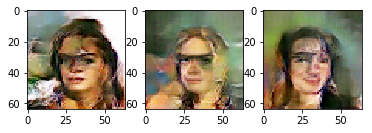

Epoch: 141,  Loss: Dec_real = 0.902, Dec_fake = 0.981,  Gen_loss = 9.764
Epoch: 142,  Loss: Dec_real = 0.496, Dec_fake = 0.314,  Gen_loss = 1.782
Epoch: 143,  Loss: Dec_real = 0.622, Dec_fake = 0.284,  Gen_loss = 1.575
Epoch: 144,  Loss: Dec_real = 0.287, Dec_fake = 0.256,  Gen_loss = 1.973
Epoch: 145,  Loss: Dec_real = 0.584, Dec_fake = 0.247,  Gen_loss = 1.837
Epoch: 146,  Loss: Dec_real = 0.453, Dec_fake = 0.355,  Gen_loss = 1.964
Epoch: 147,  Loss: Dec_real = 0.416, Dec_fake = 0.306,  Gen_loss = 2.260
Epoch: 148,  Loss: Dec_real = 0.414, Dec_fake = 0.371,  Gen_loss = 1.739
Epoch: 149,  Loss: Dec_real = 0.533, Dec_fake = 0.461,  Gen_loss = 2.031
Epoch: 150,  Loss: Dec_real = 0.640, Dec_fake = 0.237,  Gen_loss = 2.610
Epoch: 151,  Loss: Dec_real = 0.619, Dec_fake = 0.619,  Gen_loss = 1.973
Epoch: 152,  Loss: Dec_real = 0.653, Dec_fake = 0.274,  Gen_loss = 1.866
Epoch: 153,  Loss: Dec_real = 0.418, Dec_fake = 0.389,  Gen_loss = 2.267
Epoch: 154,  Loss: Dec_real = 0.674, Dec_fake = 0.4

<Figure size 720x720 with 0 Axes>

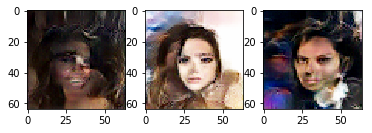

Epoch: 161,  Loss: Dec_real = 0.423, Dec_fake = 0.236,  Gen_loss = 2.723
Epoch: 162,  Loss: Dec_real = 0.477, Dec_fake = 0.751,  Gen_loss = 2.155
Epoch: 163,  Loss: Dec_real = 0.485, Dec_fake = 0.492,  Gen_loss = 1.928
Epoch: 164,  Loss: Dec_real = 0.478, Dec_fake = 0.490,  Gen_loss = 1.904
Epoch: 165,  Loss: Dec_real = 0.509, Dec_fake = 0.444,  Gen_loss = 1.797
Epoch: 166,  Loss: Dec_real = 0.000, Dec_fake = 299.998,  Gen_loss = 792.200
Epoch: 167,  Loss: Dec_real = 0.640, Dec_fake = 0.779,  Gen_loss = 1.821
Epoch: 168,  Loss: Dec_real = 0.780, Dec_fake = 0.492,  Gen_loss = 1.554
Epoch: 169,  Loss: Dec_real = 0.573, Dec_fake = 0.537,  Gen_loss = 1.613
Epoch: 170,  Loss: Dec_real = 0.567, Dec_fake = 0.361,  Gen_loss = 1.394
Epoch: 171,  Loss: Dec_real = 0.344, Dec_fake = 0.339,  Gen_loss = 1.572
Epoch: 172,  Loss: Dec_real = 0.572, Dec_fake = 0.485,  Gen_loss = 1.532
Epoch: 173,  Loss: Dec_real = 0.711, Dec_fake = 0.426,  Gen_loss = 1.830
Epoch: 174,  Loss: Dec_real = 0.367, Dec_fake =

<Figure size 720x720 with 0 Axes>

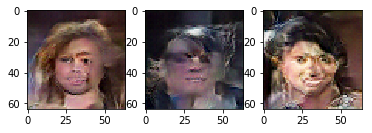

Epoch: 181,  Loss: Dec_real = 2.279, Dec_fake = 7.614,  Gen_loss = 10.093
Epoch: 182,  Loss: Dec_real = 0.556, Dec_fake = 0.577,  Gen_loss = 1.457
Epoch: 183,  Loss: Dec_real = 0.420, Dec_fake = 0.414,  Gen_loss = 1.671
Epoch: 184,  Loss: Dec_real = 0.361, Dec_fake = 0.370,  Gen_loss = 2.104
Epoch: 185,  Loss: Dec_real = 0.438, Dec_fake = 0.225,  Gen_loss = 2.119
Epoch: 186,  Loss: Dec_real = 0.332, Dec_fake = 0.325,  Gen_loss = 2.579
Epoch: 187,  Loss: Dec_real = 0.595, Dec_fake = 0.604,  Gen_loss = 2.314
Epoch: 188,  Loss: Dec_real = 0.613, Dec_fake = 0.509,  Gen_loss = 1.927
Epoch: 189,  Loss: Dec_real = 0.620, Dec_fake = 0.258,  Gen_loss = 2.546
Epoch: 190,  Loss: Dec_real = 0.454, Dec_fake = 0.335,  Gen_loss = 2.016
Epoch: 191,  Loss: Dec_real = 0.426, Dec_fake = 0.413,  Gen_loss = 2.245
Epoch: 192,  Loss: Dec_real = 1.198, Dec_fake = 0.854,  Gen_loss = 3.650
Epoch: 193,  Loss: Dec_real = 0.500, Dec_fake = 0.450,  Gen_loss = 1.955
Epoch: 194,  Loss: Dec_real = 0.590, Dec_fake = 0.

<Figure size 720x720 with 0 Axes>

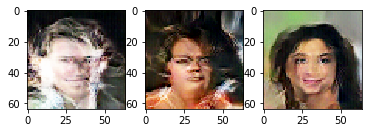

In [ ]:
train(generator, discriminator, gan, dataset, latent_dim, n_epoch, batch_size)